In [24]:
import wandb
import datetime
from argparse import Namespace
wandb.login()

True

In [25]:
import numpy as np
import pandas as pd
import random


# model interpretability
from captum.attr import IntegratedGradients

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transform
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
from einops import rearrange,reduce,repeat
from einops.layers.torch import Rearrange,Reduce
from PIL import Image, ImageFile
import copy
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [26]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

In [27]:
config=Namespace(
    project_name="self_coattn_transformer_3D_ende",
    batch_size = 16,
    epochs = 150,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    criterion = nn.CrossEntropyLoss()
    )


print(config.device)

cuda


In [28]:
root_dir="../data/Thermal Camera Images" #480x640 "..":表上級目錄
file=[]
label=["NoGas","Perfume","Smoke","Mixture"]

for i, cls in enumerate(label):
    # print(cls)
    class_dir = os.path.join(root_dir, cls)
    class_image=[f for f in os.listdir(class_dir)]
    class_image = sorted(class_image, key=lambda x: int(x.split("_")[0]))
    for img in class_image:
        file.append((os.path.join(class_dir, img), i))

file = np.array(file)

print(file)

[['../data/Thermal Camera Images/NoGas/0_NoGas.png' '0']
 ['../data/Thermal Camera Images/NoGas/1_NoGas.png' '0']
 ['../data/Thermal Camera Images/NoGas/2_NoGas.png' '0']
 ...
 ['../data/Thermal Camera Images/Mixture/1597_Mixture.png' '3']
 ['../data/Thermal Camera Images/Mixture/1598_Mixture.png' '3']
 ['../data/Thermal Camera Images/Mixture/1599_Mixture.png' '3']]


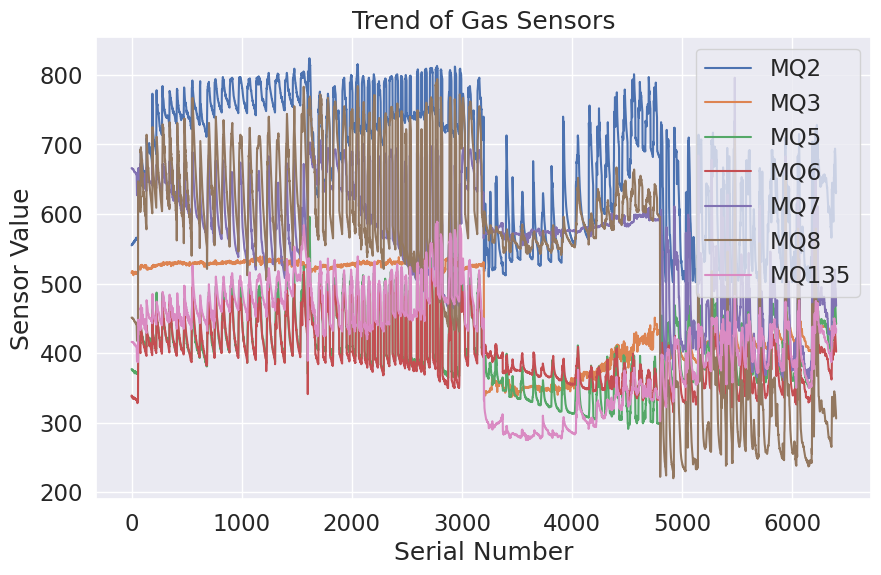

In [29]:
df=pd.read_csv("../data/Gas Sensors Measurements/Gas_Sensors_Measurements.csv")

# 繪製趨勢圖
plt.figure(figsize=(10, 6))
for column in df.columns[1:8]:  # 選擇MQ2到MQ135列
    plt.plot(df[column], label=column)

plt.xlabel('Serial Number')
plt.ylabel('Sensor Value')
plt.title('Trend of Gas Sensors')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
data=pd.read_csv("../data/Gas Sensors Measurements/Gas_Sensors_Measurements.csv")
data=data.drop("Corresponding Image Name",axis=1)
data=data.drop("Gas",axis=1)
# data=data.drop("Serial Number",axis=1)
data.insert(1,"index", range(0, len(data))) #新增feature 1-6400
data=np.array(data)

data_cat=np.concatenate((data, file), axis=1)
scaler = MinMaxScaler(feature_range=(0,1))
data_cat[:,2:9]=scaler.fit_transform(data[:,2:9]) # feature 1 (1-1600)*4|feature 2 1-6400|feature 3-9 sensor
print(data_cat)
# train_ratio = 0.6
# valid_ratio = 0.2
# test_ratio = 0.2

# # 計算相應的樣本數量
# total_samples = len(data_cat)
# num_train = int(train_ratio * total_samples)
# num_valid = int(valid_ratio * total_samples)

# # 使用 numpy 的切片功能進行分割
# train, X_temp= data_cat[:num_train], data_cat[num_train:num_train + num_valid]
# valid, test= data_cat[num_train:num_train + num_valid], data_cat[num_train + num_valid:]

indices = [i for i in range(len(data_cat)) if i%5!=0]
train_=data_cat[indices] #5120
# print(train_)
indices_tr=[i for i in indices if i%6!=0]
# print(indices_vl)
train_id=train_[:,1].astype(int)
train=train_[np.isin(train_id,indices_tr)]
indices_vl=[i for i in indices if i%6==0]
valid=train_[np.isin(train_id,indices_vl)]
indices = [i for i in range(len(data_cat)) if i%5==0]
test=data_cat[indices]
print(len(train),len(valid),len(test))
# train_,test=train_test_split(data_cat,train_size=0.8,random_state=42)
# train,valid=train_test_split(train_,train_size=0.8,random_state=42)

# sorted_indices_tr = np.argsort(train[:, 0])
# sorted_indices_vl = np.argsort(valid[:, 0])
# sorted_indices_tt = np.argsort(test[:, 0])
# train=train[sorted_indices_tr]
# valid=train[sorted_indices_vl]
# test=train[sorted_indices_tt]

y_train=train[:,-1]
# print(y_train)
MQ_train=train[:,2:9]

image_train=train[:,-2]
print(image_train)
y_valid=valid[:,-1]
MQ_valid=valid[:,2:9]
image_valid=valid[:,-2]

y_test=test[:,-1]
MQ_test=test[:,2:9]
image_test=test[:,-2]

[['0' '0' '0.1645962732919255' ... '0.44904458598726127'
  '../data/Thermal Camera Images/NoGas/0_NoGas.png' '0']
 ['1' '1' '0.1645962732919255' ... '0.44904458598726127'
  '../data/Thermal Camera Images/NoGas/1_NoGas.png' '0']
 ['2' '2' '0.16770186335403725' ... '0.44904458598726127'
  '../data/Thermal Camera Images/NoGas/2_NoGas.png' '0']
 ...
 ['1597' '6397' '0.3975155279503104' ... '0.49044585987261147'
  '../data/Thermal Camera Images/Mixture/1597_Mixture.png' '3']
 ['1598' '6398' '0.40372670807453415' ... '0.49363057324840776'
  '../data/Thermal Camera Images/Mixture/1598_Mixture.png' '3']
 ['1599' '6399' '0.4068322981366459' ... '0.5063694267515925'
  '../data/Thermal Camera Images/Mixture/1599_Mixture.png' '3']]
4267 853 1280
['../data/Thermal Camera Images/NoGas/1_NoGas.png'
 '../data/Thermal Camera Images/NoGas/2_NoGas.png'
 '../data/Thermal Camera Images/NoGas/3_NoGas.png' ...
 '../data/Thermal Camera Images/Mixture/1597_Mixture.png'
 '../data/Thermal Camera Images/Mixture/1

In [31]:
class sensordata(nn.Module):
    def __init__(self,target,MQ=None,image=None,transform=None,seq_len=12):
        self.seq_len=seq_len
        self.transform=transform
        self.img = image

        self.MQ=MQ
        self.target = target
        self.transform = transform

    def __len__(self):

        return len(self.target)-self.seq_len
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        while len(set(self.target[idx:idx+self.seq_len]))>1: #如果取到的時間序列含有2個label
            idx+=1 

        target = self.target[idx].astype(np.int64)

        # target=torch.Tensor(target)
        if self.img is not None:
            img_name =[]
            
            # for i in range(12):
            #     print("Sequence:", img_name[i])
            # print(img_name)
            # img_name=Image.fromarray(img_name)
            for i in range(idx,(idx+self.seq_len)):
                image=Image.open(self.img[i])
                
                if self.transform:
                    image = self.transform(image)
                
                img_name.append(image)
            img_name=torch.stack(img_name)
            # print(img_name)
            # image = image.permute(2,1,0)#.long()
            # print("First batch of image data:")
            # for i in range(12):
            #     print("Sequence:", image[i])
            
            if self.MQ is None:
                return img_name,target
        if self.MQ is not None:
            MQ_name = self.MQ[idx:idx+self.seq_len].astype(float)

            # target=torch.Tensor(target)
            # print("First batch of sensor data:")
            # for i in range(12):
            #     print("Sequence:", MQ_name[i])
            #     print()
            # print(MQ_name.shape) #(12,7)
            # print(target)
            # print(target)
            # print(MQ_name.shape)
            MQ_idx = torch.FloatTensor(MQ_name)
            # print(MQ_idx.size())
            if self.img is None:
                return MQ_idx,target

        return MQ_idx,img_name,target
train_transform = transforms.Compose([
    transforms.Resize((56,56)),
    transforms.RandomHorizontalFlip(), #這個不會讓圖片增加2倍，0.5的機率圖片翻轉
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((56,56)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [32]:
tr_data_all=sensordata(y_train,MQ=MQ_train,image=image_train,transform=train_transform)
vl_data_all=sensordata(y_valid,MQ_valid,image_valid,transform=test_transform)
tt_data_all=sensordata(y_test,MQ=MQ_test,image=image_test,transform=test_transform)

tr_loader_all = DataLoader(tr_data_all, shuffle=True, batch_size=config.batch_size)
vl_loader_all = DataLoader(vl_data_all, shuffle=False, batch_size=config.batch_size)
tt_loader_all=DataLoader(tt_data_all,shuffle=False, batch_size=config.batch_size)
sensor,img ,labels= next(iter(tr_loader_all))
print(sensor.shape)#包含16個batch 每個batch都是由seq_len:12筆資料組成
print(img.shape)
print(labels)
print(f'Number of samples in training and validation are {len(tr_loader_all.dataset)} and {len(vl_loader_all.dataset)}.')


torch.Size([16, 12, 7])
torch.Size([16, 12, 3, 56, 56])
tensor([3, 0, 0, 1, 2, 0, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0])
Number of samples in training and validation are 4255 and 841.


In [33]:
# 3DCNN
class SimplifiedCNN_3D(nn.Module):
    def __init__(self):
        super(SimplifiedCNN_3D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool3d((1, 4, 4))
        # self.classifier = nn.Sequential(
        #     nn.Linear(32*4*4 , 64),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(),
        #     nn.Linear(64, num_classes),
        # )

    def forward(self, x):
        x = self.features(x)
        # x = self.avgpool(x)
        # x = torch.flatten(x, 1)
        # x = self.classifier(x)
        return x

# 創建簡化版的模型
# num_classes = 4  
model_ft = SimplifiedCNN_3D().to(config.device)

In [34]:
from torchsummary import summary
summary(model_ft,(3,12,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 12, 56, 56]           2,624
              ReLU-2       [-1, 32, 12, 56, 56]               0
         MaxPool3d-3        [-1, 32, 6, 28, 28]               0
Total params: 2,624
Trainable params: 2,624
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.43
Forward/backward pass size (MB): 19.52
Params size (MB): 0.01
Estimated Total Size (MB): 19.96
----------------------------------------------------------------


In [35]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 32, patch_size: tuple = (2, 7, 7), emb_size: int = 3136, num_patches: int = None):
        super().__init__()
        self.patch_size = patch_size
        self.emb_size = emb_size

        self.projection = nn.Sequential(
            nn.Conv3d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (d) (h) (w) -> b (d h w) e'),
            nn.Linear(emb_size, 64)
        )

        # Calculate the number of patches
        self.num_patches = num_patches
        if self.num_patches is None:
            self.num_patches = (6 // patch_size[0]) * (28 // patch_size[1]) * (28 // patch_size[2])
        
        # Define the position embeddings
        self.position_embeddings = nn.Parameter(torch.randn(1, self.num_patches, 64))

    def forward(self, x):
        x = self.projection(x)
        # Add position embeddings
        x += self.position_embeddings
        return x

In [36]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000): #d_model:embedding size
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #(5000,1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) #越後面的dim頻率越小 sin填入偶數行
        pe[:, 1::2] = torch.cos(position * div_term) #cos填入奇數行
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :] #x是time series不用另外embedding
        return self.dropout(x)

In [37]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=7, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model) #(16,12,64)
        self.pos_encoder = PositionalEncoding(d_model, dropout) #(16,12,64)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        # self.decoder = nn.Linear(d_model, 16)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        # x = self.decoder(x[:, -1, :])
        return x


transformmodel = TransformerModel().to(config.device)

In [38]:
import math
import torch.nn.functional as F
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def attention(query, key, value, attn_mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if attn_mask is not None:
        scores = scores.masked_fill(attn_mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model,h,  dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadAttention, self).__init__()
        # assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4) # create 4 linear layers
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, attn_mask=None):
        if attn_mask is not None:
            # Same mask applied to all h heads.
            attn_mask = attn_mask.unsqueeze(1)
        batch_size = query.size(0)

        # print ('Before transform query: ' + str(query.size())) # (batch_size, seq_length, d_model)  
        # print ('Before transform key: ' + str(key.size()))
        # print ('Before transform value: ' + str(value.size()))

        query, key, value = [l(x) for l, x in zip(self.linears, (query, key, value))] # (batch_size, seq_length, d_model), use first 3 self.linears
        query, key, value = [x.view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for x in (query, key, value)] # (batch_size, h, seq_length, d_k)

        # print ('After transform query: ' + str(query.size()))
        # print ('After transform key: ' + str(key.size()))
        # print ('After transform value: ' + str(value.size()))


        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, attn_mask=attn_mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)
        # print(x.size())
        return self.linears[-1](x)


class PositionalWiseFeedForward(nn.Module):
    """
    Fully-connected network
    """
    def __init__(self, model_dim=64, ffn_dim=32, dropout=0.9):
        super(PositionalWiseFeedForward, self).__init__()
        self.w1 = nn.Linear(model_dim, ffn_dim)
        self.w2 = nn.Linear(ffn_dim, model_dim)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(model_dim)

    def forward(self, x):
        residual = x

        x = self.w2(F.relu(self.w1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)
        output = x
        # print(output.size())
        return output
    
##self-attention
class self_attn(nn.Module):
    """
    A layer of fusing features
    """
    def __init__(self, model_dim=64, num_heads=2, ffn_dim=128, dropout=0.2):
        super(self_attn, self).__init__()
        self.attention_ = MultiHeadAttention(model_dim, num_heads, dropout)
        self.feed_forward_= PositionalWiseFeedForward(model_dim, ffn_dim, dropout)

        self.fusion_linear = nn.Linear(model_dim, model_dim*2)
        self.relu=nn.ReLU()
        self.fusion_linear1=nn.Linear(model_dim*2, model_dim)

    def forward(self, input, attn_mask=None):

        output= self.attention_(input, input, input,
                                 attn_mask)

        #print('attention out_shape:{}'.format(output.shape))
        output = self.feed_forward_(output)
        output = self.fusion_linear(output)
        output=self.fusion_linear1(self.relu(output))
        # output = self.fusion_linear(output)

        return output

##co-attention  
class co_attn(nn.Module):
    """
    A layer of fusing features
    """
    def __init__(self, model_dim=64, num_heads=2, ffn_dim=128, dropout=0.2):
        super(co_attn, self).__init__()
        self.attention_1 = MultiHeadAttention(model_dim, num_heads, dropout)
        self.attention_2 = MultiHeadAttention(model_dim, num_heads, dropout)

        self.feed_forward_1 = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)
        self.feed_forward_2 = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)

        self.fusion_linear = nn.Linear(model_dim, model_dim*2)
        self.relu=nn.ReLU()
        self.fusion_linear1=nn.Linear(model_dim*2, model_dim)

    def forward(self, image_output, sensor_output, attn_mask=None):

        output_1 = self.attention_1(image_output, sensor_output, sensor_output,
                                 attn_mask)

        output_2 = self.attention_2(sensor_output, image_output, image_output,
                                 attn_mask)


        #print('attention out_shape:{}'.format(output.shape))
        output_1 = self.feed_forward_1(output_1) #(16,48,64)
        output_2 = self.feed_forward_2(output_2) #(16,12,64)

        output = torch.cat([output_1, output_2], dim=1) #torch.Size([16, 60, 64])
        output = self.fusion_linear(output)
        output=self.fusion_linear1(self.relu(output))

        # print(f"123 {output.size()}")
        return output

##self-co-attention
class self_co_attn(nn.Module):
    """
    A layer of fusing features
    """
    def __init__(self, model_dim=64, num_heads=4, ffn_dim=32, dropout=0.2):
        super(self_co_attn, self).__init__()
        self.self_attn=self_attn(model_dim=64, num_heads=2, ffn_dim=8, dropout=0.2)
        self.attention_1 = MultiHeadAttention(model_dim, num_heads, dropout)
        self.attention_2 = MultiHeadAttention(model_dim, num_heads, dropout)

        self.feed_forward_1 = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)
        self.feed_forward_2 = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)

        self.fusion_linear = nn.Linear(model_dim, model_dim*2)
        self.relu=nn.ReLU()
        self.fusion_linear1=nn.Linear(model_dim*2, model_dim)

    def forward(self, image_output, sensor_output, attn_mask=None):
        sensor_output=self.self_attn(sensor_output,attn_mask)
        
        output_1 = self.attention_1(image_output, sensor_output, sensor_output,
                                 attn_mask)
        output_2 = self.attention_2(sensor_output, image_output, image_output,
                                 attn_mask)

        #print('attention out_shape:{}'.format(output.shape))
        output_1 = self.feed_forward_1(output_1)
        output_2 = self.feed_forward_2(output_2)

        output = torch.cat([output_1, output_2], dim=1)
        output = self.fusion_linear(output)
        output=self.fusion_linear1(self.relu(output))

        return output

In [39]:
# -------------------------
# ---- self_attn+co_attn----
# -------------------------
class MCA_ED(nn.Module):
    def __init__(self, model_dim,num_heads,ffn_dim,dropout,num_layers):
        super(MCA_ED, self).__init__()

        self.enc_list = nn.ModuleList([
            self_attn(model_dim, num_heads, ffn_dim, dropout) 
            for _ in range(num_layers)
        ])
        self.dec_list = nn.ModuleList([
            self_co_attn(model_dim, num_heads, ffn_dim, dropout)
            for _ in range(num_layers)
        ])
        self.fusion_linear = nn.Linear(model_dim, model_dim*2)
        self.relu=nn.ReLU()
        self.fusion_linear1=nn.Linear(model_dim*2, model_dim)

    def forward(self, x, y, attn_mask=None): #attn_mask=None?
        #x=image y=sensor
        # Get hidden vector
        # #encoder-decoder
        for enc in self.enc_list:
            x = enc(x, attn_mask)
    
        for dec in self.dec_list:
            y = dec(x, y, attn_mask)
        # stacking
        # selfx=[]
        # for enc in self.enc_list:
        #     x = enc(x, attn_mask)
        #     selfx.append(x)
        
        # for i,dec in enumerate(self.dec_list):
        #     x=selfx[i]
        #     y = dec(x, y, attn_mask)

        output = torch.cat([x,y], dim=1)
        # print(output.size())
        output = self.fusion_linear(output)
        output=self.fusion_linear1(self.relu(output))

        return output

In [40]:
class NetShareFusion(nn.Module):
    def __init__(self,
                 model_dim,
                 num_labels=4,
                 num_layers=1,
                 num_heads=2,
                 ffn_dim=32,
                 dropout=0.2):

        super(NetShareFusion, self).__init__()

        self.model_dim = model_dim
        # self.drop_and_BN = drop_and_BN

        self.dropout = nn.Dropout(dropout)

        #sequence
        self.transformer=transformmodel
        # self.linear0=nn.Linear(model_dim,64)
        self.bn_sequence = nn.BatchNorm1d(64)

        #image
        self.vgg=model_ft
        self.emb=PatchEmbedding()
        # self.vgg = vgg(model_dim, pthfile)
        # self.linear_image = nn.Linear(256, model_dim)
        self.bn_vgg = nn.BatchNorm1d(64)


        #multimodal fusion
        self.backbone=MCA_ED(model_dim,num_heads,ffn_dim,dropout,num_layers)

        #classifier
        self.linear1 = nn.Linear(model_dim, 16)
        # self.bn_1 = nn.BatchNorm1d(32)
        self.linear2 = nn.Linear(16, num_labels)
        self.softmax = nn.Softmax(dim=1)

    def drop_BN_layer(self, x, part='seq'):
        if part == 'seq':
            bn = self.bn_sequence
        elif part == 'vgg':
            bn = self.bn_vgg

        if self.drop_and_BN == 'drop-BN':
            x = self.dropout(x)
            x = bn(x)
        elif self.drop_and_BN == 'BN-drop':
            x = bn(x)
            x = self.dropout(x)
        elif self.drop_and_BN == 'drop-only':
            x = self.dropout(x)
        elif self.drop_and_BN == 'BN-only':
            x = bn(x)
        elif self.drop_and_BN == 'none':
            pass

        return x

    def forward(self, image,sensor
                 ,attn_mask):

        image=image.transpose(1, 2)
        #visual feature
        output = self.vgg(image)
        # print(output.size())
        output = self.emb(output)
        # print(output.size())
        
        # output = F.relu(self.linear_image(output))
        # output = output.permute(0, 2, 1)
        # # print(output.size())
        # output = self.drop_BN_layer(output, part='vgg') #對embedd size做normalize
        # output = output.permute(0, 2, 1)


        #sequence
        se_out=self.transformer(sensor)
        # print(se_out.size())
        # se_out = se_out.permute(0, 2, 1)
        # se_out=self.drop_BN_layer(se_out,part="seq")
        # se_out = se_out.permute(0, 2, 1)


        # for fusion_layer in self.fusion_layers:
        #     output = fusion_layer(output, se_out, attn_mask)

        output= self.backbone(
            output, 
            se_out,
            attn_mask
        )
            # se_out = se_out.permute(0, 2, 1)
            # se_out=self.drop_BN_layer(se_out,part="seq")
            # se_out = se_out.permute(0, 2, 1)
            # print('fusion output_shape:{}'.format(se_out.shape))

        output = torch.relu(self.linear1(output))
        # output = self.dropout(output)
        # output = self.bn_1(output)
        output = self.linear2(output)  
        output=output.mean(dim=1)#(16,4)
        # print('output_size:{}'.format(output.shape))
        y_pred_prob = self.softmax(output)

        return output, y_pred_prob

In [41]:
model = NetShareFusion(
            num_layers=2,
            num_heads=2,
            model_dim=64,
            dropout=0.2).to(config.device)

In [42]:
def train_combined(model,train_loader,device, optimizer, loss_fn):
    model.train()

    n_corrects = 0
    total = 0
    train_loss = 0.
    step = 0
    for idx, (sensor_data,img_data,label) in enumerate(train_loader):
        img_data= img_data.to(device)
        sensor_data=sensor_data.to(device)
        labels=label.to(device)
        optimizer.zero_grad()


        output = model(img_data,sensor_data,attn_mask=None)
        loss = loss_fn(output[0], labels)

        _, predictions = torch.max(output[1], dim=1)
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        train_loss += loss.item()


        loss.backward()
        optimizer.step()

        current_lr = optimizer.param_groups[0]["lr"]
        step += 1

        train_accuracy = 100. * n_corrects/total

        avg_train_loss = train_loss/(idx+1)
        if (idx+1) % 16 == 0:
            print(f'Batch: [{idx+1}/{len(train_loader)}], Training Loss: {avg_train_loss:.3f} | Training Acc: {train_accuracy:.2f}% | lr: {current_lr:.5f}')

    avg_train_loss = train_loss/(step+1)
    train_accuracy = 100. * n_corrects/total
    return avg_train_loss, train_accuracy

def valid_combined(model,valid_loader,device, loss_fn):
    model.eval()


    n_corrects = 0
    total = 0
    valid_loss = 0.
    for idx, (sensor_data,img_data,label ) in enumerate(valid_loader):
        with torch.no_grad():
            img_data= img_data.to(device)
            sensor_data=sensor_data.to(device)
            labels=label.to(device)


        output = model(img_data,sensor_data,attn_mask=None)
        loss = loss_fn(output[0], labels)
        _, predictions = torch.max(output[1], dim=1)
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        valid_loss += loss.item()
        idx += 1
    avg_valid_loss = valid_loss/(idx+1)
    valid_accuracy = 100 * n_corrects/total
    return avg_valid_loss, valid_accuracy,model
def test_combined(model, test_loader, device):
    model.eval()

    n_corrects = 0
    total = 0
    all_predictions = []
    all_labels = []

    for idx, (sensor_data, img_data, label) in enumerate(test_loader):

        with torch.no_grad():
            img_data = img_data.to(device)
            sensor_data = sensor_data.to(device)
            labels = label.to(device)

        output_combined = model(img_data, sensor_data,attn_mask=None)

        _, predictions = torch.max(output_combined[1], dim=1)
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    valid_accuracy = 100 * n_corrects / total
    # Compute confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.5)  # Adjust font size
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=range(4), yticklabels=range(4))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute precision, recall, and F1 score
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)
    
    return valid_accuracy, confusion_mat, precision, recall, f1_score

In [43]:
# -------------------------
# ---- earlystopper ----
# -------------------------
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss,model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            print('Saving model (loss = {:.4f})'
            .format(self.min_validation_loss))
            torch.save(model.state_dict(), 'models/SELF_CO_CNN_TRANSFORMER.pth')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f"|||early stop:{self.counter}")
            if self.counter >= self.patience:
                return True
        return False

In [44]:
optimizer = optim.SGD(list(model_ft.parameters()) + list(transformmodel.parameters()) +
                    list(model.parameters()), lr=0.0005, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.5, patience=7, verbose=True)
# -------------------------
# ---- train model ----
# -------------------------
early_stopper = EarlyStopper(patience=10)
epoch_nums=[]
training_loss=[]
validation_loss=[]

nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
wandb.init(project=config.project_name, config = config.__dict__, name = nowtime, save_code=True)
model.run_id = wandb.run.id

for epoch in range(config.epochs):
    
    train_loss, train_accuracy = train_combined(model,tr_loader_all, config.device, optimizer, config.criterion)
    valid_loss, valid_accuracy,model= valid_combined(model,vl_loader_all, config.device, config.criterion)
    print(f'[{epoch+1}/{config.epochs}] | validation loss: {valid_loss:.4f} | validation accuracy: {valid_accuracy:.2f}%')
    scheduler.step(valid_loss)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(valid_loss)
    if early_stopper.early_stop(valid_loss,model):
        break
    
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss,"train_acc":train_accuracy,"valid_acc":valid_accuracy})

wandb.finish()


Batch: [16/266], Training Loss: 1.385 | Training Acc: 28.12% | lr: 0.00050
Batch: [32/266], Training Loss: 1.388 | Training Acc: 26.76% | lr: 0.00050
Batch: [48/266], Training Loss: 1.391 | Training Acc: 25.52% | lr: 0.00050
Batch: [64/266], Training Loss: 1.391 | Training Acc: 25.78% | lr: 0.00050
Batch: [80/266], Training Loss: 1.393 | Training Acc: 24.61% | lr: 0.00050
Batch: [96/266], Training Loss: 1.391 | Training Acc: 25.26% | lr: 0.00050
Batch: [112/266], Training Loss: 1.392 | Training Acc: 24.94% | lr: 0.00050
Batch: [128/266], Training Loss: 1.391 | Training Acc: 25.34% | lr: 0.00050
Batch: [144/266], Training Loss: 1.390 | Training Acc: 25.87% | lr: 0.00050
Batch: [160/266], Training Loss: 1.390 | Training Acc: 25.78% | lr: 0.00050
Batch: [176/266], Training Loss: 1.390 | Training Acc: 25.57% | lr: 0.00050
Batch: [192/266], Training Loss: 1.391 | Training Acc: 25.13% | lr: 0.00050
Batch: [208/266], Training Loss: 1.391 | Training Acc: 25.09% | lr: 0.00050
Batch: [224/266], 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▁▁▁▁▁▂▃▃▃▃▃▃▄▆▆▆▆▇▇▇▇▇█████████████████
train_loss,██████████▇▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_acc,▁▁▁▁▁▃▃▄▃▃▃▃▄▅▇▆▇▇▇▇▇██▇███▇█▇██████████
valid_loss,██████████▇▆▅▅▃▃▂▂▂▂▂▁▁▃▁▁▁▂▁▂▁▂▁▁▂▁▁▁▂▁
epoch,56
train_acc,99.41246
train_loss,0.01634
valid_acc,95.36266
valid_loss,0.12308


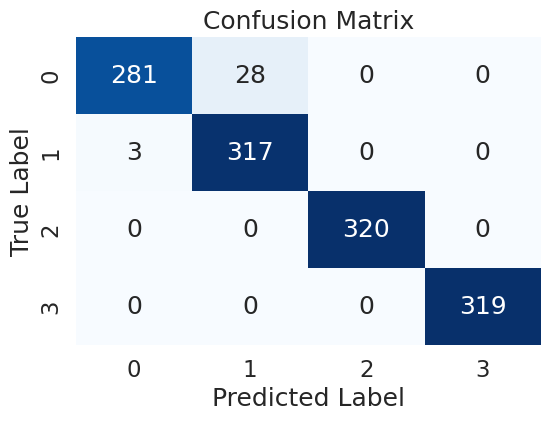

test acc:97.5552


In [45]:
test_acc, confusion_mat, precision, recall, f1_score= test_combined(model,tt_loader_all, config.device)
print(f"test acc:{test_acc:.4f}")

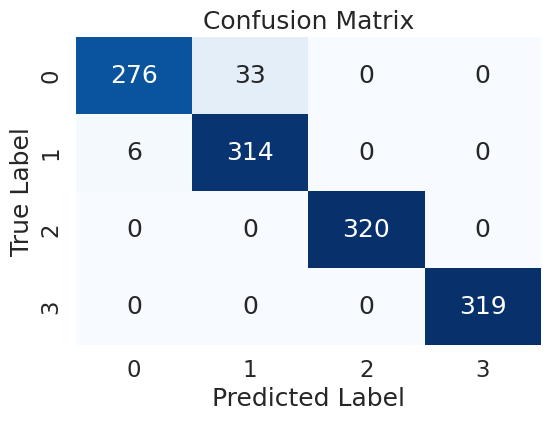

test acc:96.9243


In [46]:
# -------------------------
# ---- best model ----
# -------------------------
del model
model = NetShareFusion(
            num_layers=2,
            num_heads=2,
            model_dim=64,
            dropout=0.2).to(config.device)
ckpt = torch.load('models/SELF_CO_CNN_TRANSFORMER.pth', map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
test_acc, confusion_mat, precision, recall, f1_score= test_combined(model,tt_loader_all, config.device)
print(f"test acc:{test_acc:.4f}")